In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
from gpflow.inducing_variables import InducingVariables
from gpflow.base import TensorLike
from gpflow.utilities import to_default_float
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.ci_utils import ci_niter

In [2]:
# VFF give structured covariance matrices that are computationally efficient.
# We take advantage of this using TensorFlow's LinearOperators:
BlockDiag = tf.linalg.LinearOperatorBlockDiag
Diag = tf.linalg.LinearOperatorDiag
LowRank = tf.linalg.LinearOperatorLowRankUpdate

In [3]:
class FourierFeatures1D(InducingVariables):
    def __init__(self, a, b, M):
        """
        `a` and `b` define the interval [a, b] of the Fourier representation.
        `M` specifies the number of frequencies to use.
        """
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

        # integer array defining the frequencies, ω_m = 2π (b - a)/m:
        self.ms = np.arange(M)

    @property
    def num_inducing(self):
        """ number of inducing variables (defines dimensionality of q(u)) """
        return 2 * tf.shape(self.ms)[0] - 1  # `M` cosine and `M-1` sine components

In [5]:
ind_var = FourierFeatures1D(-2,2,10)

In [20]:
@cov.Kuu.register(FourierFeatures1D, gpflow.kernels.Matern12)
def Kuu_matern12_fourierfeatures1d(inducing_variable, kernel, jitter=None):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    # Cosine block:
    lamb = 1.0 / kernel.lengthscales
    two_or_four = to_default_float(tf.where(omegas == 0, 2.0, 4.0))
    d_cos = (
        (b - a) * (tf.square(lamb) + tf.square(omegas)) / lamb / kernel.variance / two_or_four
    )  # eq. (111)
    v_cos = tf.ones_like(d_cos) / tf.sqrt(kernel.variance)  # eq. (110)
    cosine_block = LowRank(Diag(d_cos, is_positive_definite=True), v_cos[:, None])

    # Sine block:
    omegas = omegas[tf.not_equal(omegas, 0)]  # the sine block does not include omega=0
    d_sin = (
        (b - a) * (tf.square(lamb) + tf.square(omegas)) / lamb / kernel.variance / 4.0
    )  # eq. (113)
    sine_block = Diag(d_sin, is_positive_definite=True)

    return BlockDiag([cosine_block, sine_block])


@cov.Kuf.register(FourierFeatures1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_fourierfeatures1d(inducing_variable, kernel, X):

    X = tf.squeeze(X, axis=1)

    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)

    omegas = 2.0 * np.pi * ms / (b - a)
    Kuf_cos = tf.cos(omegas[:, None] * (X[None, :] - a))
    omegas_sin = omegas[tf.not_equal(omegas, 0)]  # don't compute zero frequency
    Kuf_sin = tf.sin(omegas_sin[:, None] * (X[None, :] - a))

    # correct Kuf outside [a, b] -- see Table 1
    Kuf_sin = tf.where((X < a) | (X > b), tf.zeros_like(Kuf_sin), Kuf_sin)  # just zero

    left_tail = tf.exp(-tf.abs(X - a) / kernel.lengthscales)[None, :]
    right_tail = tf.exp(-tf.abs(X - b) / kernel.lengthscales)[None, :]
    Kuf_cos = tf.where(X < a, left_tail, Kuf_cos)  # replace with left tail
    Kuf_cos = tf.where(X > b, right_tail, Kuf_cos)  # replace with right tail

    return tf.concat([Kuf_cos, Kuf_sin], axis=0)


@cov.Kuu.register(FourierFeatures1D, gpflow.kernels.Matern32)
def Kuu_matern32_fourierfeatures1d(inducing_variable, kernel, jitter=None):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    # Cosine block: eq. (114)
    lamb = np.sqrt(3.0) / kernel.lengthscales
    four_or_eight = to_default_float(tf.where(omegas == 0, 4.0, 8.0))
    d_cos = (
        (b - a)
        * tf.square(tf.square(lamb) + tf.square(omegas))
        / tf.pow(lamb, 3)
        / kernel.variance
        / four_or_eight
    )
    v_cos = tf.ones_like(d_cos) / tf.sqrt(kernel.variance)
    cosine_block = LowRank(Diag(d_cos, is_positive_definite=True), v_cos[:, None])

    # Sine block: eq. (115)
    omegas = omegas[tf.not_equal(omegas, 0)]  # don't compute omega=0
    d_sin = (
        (b - a)
        * tf.square(tf.square(lamb) + tf.square(omegas))
        / tf.pow(lamb, 3)
        / kernel.variance
        / 8.0
    )
    v_sin = omegas / lamb / tf.sqrt(kernel.variance)
    sine_block = LowRank(Diag(d_sin, is_positive_definite=True), v_sin[:, None])

    return BlockDiag([cosine_block, sine_block])  # eq. (116)


@cov.Kuf.register(FourierFeatures1D, gpflow.kernels.Matern32, TensorLike)
def Kuf_matern32_fourierfeatures1d(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2.0 * np.pi * ms / (b - a)

    Kuf_cos = tf.cos(omegas[:, None] * (X[None, :] - a))
    omegas_sin = omegas[tf.not_equal(omegas, 0)]  # don't compute zeros freq.
    Kuf_sin = tf.sin(omegas_sin[:, None] * (X[None, :] - a))

    # correct Kuf outside [a, b] -- see Table 1

    def tail_cos(delta_X):
        arg = np.sqrt(3) * tf.abs(delta_X) / kernel.lengthscales
        return (1 + arg) * tf.exp(-arg)[None, :]

    Kuf_cos = tf.where(X < a, tail_cos(X - a), Kuf_cos)
    Kuf_cos = tf.where(X > b, tail_cos(X - b), Kuf_cos)

    def tail_sin(delta_X):
        arg = np.sqrt(3) * tf.abs(delta_X) / kernel.lengthscales
        return delta_X[None, :] * tf.exp(-arg) * omegas_sin[:, None]

    Kuf_sin = tf.where(X < a, tail_sin(X - a), Kuf_sin)
    Kuf_sin = tf.where(X > b, tail_sin(X - b), Kuf_sin)

    return tf.concat([Kuf_cos, Kuf_sin], axis=0)

In [1]:
test = Kuf_matern12_fourierfeatures1d(ind_var, gpflow.kernels.Matern12(), data[0])

NameError: name 'Kuf_matern12_fourierfeatures1d' is not defined

In [51]:
@kl.prior_kl.register(FourierFeatures1D, gpflow.kernels.Kernel, TensorLike, TensorLike)
def prior_kl_vff(inducing_variable, kernel, q_mu, q_sqrt, whiten=False):
    if whiten:
        raise NotImplementedError
    K = cov.Kuu(inducing_variable, kernel)
    return gauss_kl_vff(q_mu, q_sqrt, K)


def gauss_kl_vff(q_mu, q_sqrt, K):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, K)

    q_mu is a vector [N, 1] that contains the mean.
    q_sqrt is a matrix that is the lower triangular square-root matrix of the covariance of q.

    K is a positive definite matrix: the covariance of p.
    NOTE: K is a LinearOperator that provides efficient methjods
        for solve(), log_abs_determinant(), and trace()
    """
    # KL(N₀ || N₁) = ½ [tr(Σ₁⁻¹ Σ₀) + (μ₁ - μ₀)ᵀ Σ₁⁻¹ (μ₁ - μ₀) - k + ln(det(Σ₁)/det(Σ₀))]
    # N₀ = q; μ₀ = q_mu, Σ₀ = q_sqrt q_sqrtᵀ
    # N₁ = p; μ₁ = 0, Σ₁ = K
    # KL(q || p) =
    #     ½ [tr(K⁻¹ q_sqrt q_sqrtᵀA + q_muᵀ K⁻¹ q_mu - k + logdet(K) - logdet(q_sqrt q_sqrtᵀ)]
    # k = number of dimensions, if q_sqrt is m x m this is m²
    Kinv_q_mu = K.solve(q_mu)

    mahalanobis_term = tf.squeeze(tf.matmul(q_mu, Kinv_q_mu, transpose_a=True))

    # GPflow: q_sqrt is num_latent_gps x N x N
    num_latent_gps = to_default_float(tf.shape(q_mu)[1])
    logdet_prior = num_latent_gps * K.log_abs_determinant()

    product_of_dimensions__int = tf.reduce_prod(tf.shape(q_sqrt)[:-1])  # dimensions are integers
    constant_term = to_default_float(product_of_dimensions__int)

    Lq = tf.linalg.band_part(q_sqrt, -1, 0)  # force lower triangle
    logdet_q = tf.reduce_sum(tf.math.log(tf.square(tf.linalg.diag_part(Lq))))

    # S = tf.matmul(q_sqrt, q_sqrt, transpose_b=True)
    # trace_term = tf.trace(K.solve(S))
    trace_term = tf.squeeze(
        tf.reduce_sum(Lq * K.solve(Lq), axis=[-1, -2])
    )  # [O(N²) instead of O(N³)

    twoKL = trace_term + mahalanobis_term - constant_term + logdet_prior - logdet_q
    return 0.5 * twoKL

In [52]:
import gpflow.posteriors


class VFFPosterior(gpflow.posteriors.BasePosterior):
    def _conditional_fused(self, Xnew, full_cov, full_output_cov):
        """
        Xnew is a tensor with the points of the data or minibatch, shape N x D
        """
        if full_output_cov:
            raise NotImplementedError

        f = self._q_dist.q_mu
        q_sqrt = self._q_dist.q_sqrt

        # num_data = tf.shape(Xnew)[0]  # M
        num_func = tf.shape(f)[1]  # K

        Kuu = cov.Kuu(self.X_data, self.kernel)  # this is now a LinearOperator
        Kuf = cov.Kuf(self.X_data, self.kernel, Xnew)  # still a Tensor

        KuuInv_Kuf = Kuu.solve(Kuf)

        # compute the covariance due to the conditioning
        if full_cov:
            fvar = self.kernel(Xnew) - tf.matmul(Kuf, KuuInv_Kuf, transpose_a=True)
            shape = (num_func, 1, 1)
        else:
            KufT_KuuInv_Kuf_diag = tf.reduce_sum(Kuf * KuuInv_Kuf, axis=-2)
            fvar = self.kernel(Xnew, full_cov=False) - KufT_KuuInv_Kuf_diag
            shape = (num_func, 1)
        fvar = tf.expand_dims(fvar, 0) * tf.ones(
            shape, dtype=gpflow.default_float()
        )  # K x N x N or K x N

        if self.whiten:
            raise NotImplementedError

        A = KuuInv_Kuf

        # construct the conditional mean
        fmean = tf.matmul(A, f, transpose_a=True)

        if q_sqrt is not None:
            if q_sqrt.get_shape().ndims == 2:
                # LTA = A * tf.expand_dims(q_sqrt, 2)  # K x M x N
                # won't work  # make ticket for this?
                raise NotImplementedError
            elif q_sqrt.get_shape().ndims == 3:
                # L = tf.matrix_band_part(tf.transpose(q_sqrt, (2, 0, 1)), -1, 0)  # K x M x M

                # K x M x N
                # A_tiled = tf.expand_dims(A.get(), 0) * tf.ones((num_func, 1, 1), dtype=float_type)

                # LTA = tf.matmul(L, A_tiled, transpose_a=True)  # K x M x N
                # TODO the following won't work for K > 1
                assert q_sqrt.shape[0] == 1
                # LTA = (A.T @ DenseMatrix(q_sqrt[:,:,0])).T.get()[None, :, :]
                ATL = tf.matmul(A, q_sqrt, transpose_a=True)
            else:
                raise ValueError("Bad dimension for q_sqrt: %s" % str(q_sqrt.get_shape().ndims))
            if full_cov:
                # fvar = fvar + tf.matmul(LTA, LTA, transpose_a=True)  # K x N x N
                fvar = fvar + tf.matmul(ATL, ATL, transpose_b=True)  # K x N x N
            else:
                # fvar = fvar + tf.reduce_sum(tf.square(LTA), 1)  # K x N
                fvar = fvar + tf.reduce_sum(tf.square(ATL), 2)  # K x N
        fvar = tf.transpose(fvar)  # N x K or N x N x K

        return fmean, fvar

    # We can also provide a conditional that precomputes as much as possible,
    # to speed up predictions:

    def _precompute(self):
        Kuu = cov.Kuu(self.X_data, self.kernel)  # this is now a LinearOperator

        q_mu = self._q_dist.q_mu
        q_sqrt = self._q_dist.q_sqrt

        if self.whiten:
            raise NotImplementedError
        else:
            # alpha = Kuu⁻¹ q_mu
            alpha = Kuu.solve(q_mu)  # type: tf.Tensor

        if self.whiten:
            raise NotImplementedError
        else:
            # Qinv = Kuu⁻¹ - Kuu⁻¹ S Kuu⁻¹
            KuuInv_qsqrt = Kuu.solve(q_sqrt)
            KuuInv_covu_KuuInv = tf.matmul(KuuInv_qsqrt, KuuInv_qsqrt, transpose_b=True)

        Qinv = Kuu.inverse().to_dense() - KuuInv_covu_KuuInv

        return alpha, Qinv

    def _conditional_with_precompute(self, cache, Xnew, full_cov, full_output_cov):
        alpha, Qinv = cache

        if full_output_cov:
            raise NotImplementedError

        Kuf = cov.Kuf(self.X_data, self.kernel, Xnew)  # still a Tensor

        # construct the conditional mean
        fmean = tf.matmul(Kuf, alpha, transpose_a=True)

        num_func = tf.shape(alpha)[1]  # K
        Qinv_Kuf = tf.matmul(Qinv, Kuf)

        # compute the covariance due to the conditioning
        if full_cov:
            fvar = self.kernel(Xnew) - tf.matmul(Kuf, Qinv_Kuf, transpose_a=True)
        else:
            KufT_Qinv_Kuf_diag = tf.reduce_sum(Kuf * Qinv_Kuf, axis=-2)
            fvar = self.kernel(Xnew, full_cov=False) - KufT_Qinv_Kuf_diag
        fvar = tf.transpose(fvar)

        return fmean, fvar

In [53]:
@gpflow.posteriors.get_posterior_class.register(gpflow.kernels.Kernel, FourierFeatures1D)
def _get_posterior_vff(kernel, inducing_variable):
    return VFFPosterior

In [54]:
Mf = 2
M = 2 * Mf - 1
kernel = gpflow.kernels.Matern32()
inducing_variable = FourierFeatures1D(-0.5, 1.5, Mf)

Xnew = np.random.rand(7, 1)
f = np.random.randn(M, 1)
q_sqrt = tf.convert_to_tensor(np.tril(np.random.randn(1, M, M)))

conditional_f_mean, conditional_f_var = gpflow.conditionals.conditional(
    Xnew, inducing_variable, kernel, f, q_sqrt=q_sqrt, white=False, full_cov=True
)

posterior = VFFPosterior(kernel, inducing_variable, f, q_sqrt, whiten=False, precompute_cache=None)
posterior_f_mean, posterior_f_var = posterior.fused_predict_f(Xnew, full_cov=True)

np.testing.assert_array_equal(conditional_f_mean, posterior_f_mean)
np.testing.assert_array_equal(conditional_f_var, posterior_f_var)

In [7]:
X = np.linspace(-2, 2, 510)
Xnew = np.linspace(-4, 4, 501)


def f(x):
    return np.cos(2 * np.pi * x / 4 * 2)


F = f(X)
Fnew = f(Xnew)
noise_scale = 0.1
np.random.seed(1)
Y = F + np.random.randn(*F.shape) * noise_scale

data = (X.reshape(-1, 1), Y.reshape(-1, 1))

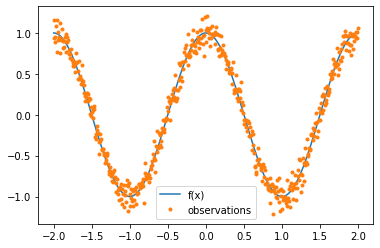

In [8]:
plt.figure()
plt.plot(X, F, label="f(x)")
plt.plot(X, Y, ".", label="observations")
plt.legend()
plt.show()

In [57]:
Mfreq = 9
m = gpflow.models.SVGP(
    kernel=gpflow.kernels.Matern32(),
    likelihood=gpflow.likelihoods.Gaussian(variance=noise_scale ** 2),
    inducing_variable=FourierFeatures1D(-1, 1, Mfreq),
    num_data=len(X),
    whiten=False,
)
gpflow.set_trainable(m.kernel, False)
gpflow.set_trainable(m.likelihood, False)
gpflow.set_trainable(m.inducing_variable, True)  # whether to optimize bounds [a, b]

In [58]:
opt = gpflow.optimizers.Scipy()
opt.minimize(
    m.training_loss_closure(data),
    m.trainable_variables,
    options=dict(maxiter=ci_niter(5000)),
)

gpflow.utilities.print_summary(m, fmt="notebook")

2022-02-07 15:32:28.188007: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:207] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2022-02-07 15:32:28.188117: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:207] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.


InvalidArgumentError: Graph execution error:

Detected at node 'LinearOperatorLowRankUpdate_ds_LinearOperatorLowRankUpdate/solve/split' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_30632/2095135803.py", line 2, in <module>
      opt.minimize(
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 95, in minimize
      return scipy.optimize.minimize(
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
      self._update_fun()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
      self._update_fun_impl()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
      self.f = fun_wrapped(self.x)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
      self._compute_if_needed(x, *args)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
      fg = self.fun(x, *args)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 137, in _eval
      loss, grad = _tf_eval(tf.convert_to_tensor(x))
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 119, in _tf_eval
      if first_call:
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 121, in _tf_eval
      loss, grads = _compute_loss_and_gradients(
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 224, in _compute_loss_and_gradients
      loss = loss_closure()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/training_mixins.py", line 131, in closure
      return training_loss(data)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/training_mixins.py", line 99, in training_loss
      return self._training_loss(data)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/model.py", line 56, in _training_loss
      return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/svgp.py", line 139, in maximum_log_likelihood_objective
      return self.elbo(data)
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/svgp.py", line 147, in elbo
      kl = self.prior_kl()
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/gpflow/models/svgp.py", line 135, in prior_kl
      self.inducing_variable, self.kernel, self.q_mu, self.q_sqrt, whiten=self.whiten
    File "/home/jake/.virtualenvs/splines_gpu/lib/python3.8/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
      return func(*args, **kwargs)
    File "/tmp/ipykernel_30632/3655681043.py", line 6, in prior_kl_vff
      return gauss_kl_vff(q_mu, q_sqrt, K)
    File "/tmp/ipykernel_30632/3655681043.py", line 30, in gauss_kl_vff
      Kinv_q_mu = K.solve(q_mu)
Node: 'LinearOperatorLowRankUpdate_ds_LinearOperatorLowRankUpdate/solve/split'
Determined shape must either match input shape along split_dim exactly if fully specified, or be less than the size of the input along split_dim if not fully specified.  Got: 18
	 [[{{node LinearOperatorLowRankUpdate_ds_LinearOperatorLowRankUpdate/solve/split}}]] [Op:__inference__tf_eval_87878]

In [37]:
m_ip = gpflow.models.SVGP(
    kernel=gpflow.kernels.Matern32(),
    likelihood=gpflow.likelihoods.Gaussian(variance=noise_scale ** 2),
    inducing_variable=np.linspace(-2, 2, Mfreq * 2 - 1)[:, None],
    num_data=len(X),
    whiten=False,
)
gpflow.set_trainable(m_ip.kernel, False)
gpflow.set_trainable(m_ip.likelihood, False)
gpflow.set_trainable(m_ip.inducing_variable, True)  # whether to optimize inducing point locations

In [38]:
opt = gpflow.optimizers.Scipy()
opt.minimize(
    m_ip.training_loss_closure(data),
    m_ip.trainable_variables,
    options=dict(maxiter=ci_niter(5000)),
)

gpflow.utilities.print_summary(m_ip, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,False,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,False,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(17, 1)",float64,[[-1.93002865...
SVGP.q_mu,Parameter,Identity,,True,"(17, 1)",float64,[[0.96123628...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 17, 17)",float64,"[[[2.16545455e-02, 0.00000000e+00, 0.00000000e+00..."


In [39]:
m_ref = gpflow.models.GPR((X.reshape(-1, 1), Y.reshape(-1, 1)), kernel=gpflow.kernels.Matern32())
m_ref.likelihood.variance = np.array(noise_scale ** 2).astype(np.float64)
gpflow.set_trainable(m_ref.kernel, False)
gpflow.set_trainable(m_ref.likelihood, False)

# Because we fixed the kernel and likelihood hyperparameters, we don't need to optimize anything.

gpflow.utilities.print_summary(m_ref, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,False,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,False,(),float64,1


In [40]:
exact_gpr_lml = m_ref.log_marginal_likelihood().numpy().item()
print("LML (exact GPR) =", exact_gpr_lml)
ip_svgp_elbo = m_ip.elbo(data).numpy().item()
print("ELBO (SVGP, inducing points) =", ip_svgp_elbo)
vff_svgp_elbo = m.elbo(data).numpy().item()
print("ELBO (SVGP, Fourier features) =", vff_svgp_elbo)

LML (exact GPR) = 402.2158074486242
ELBO (SVGP, inducing points) = 365.31217840830595
ELBO (SVGP, Fourier features) = 155.34990239084598


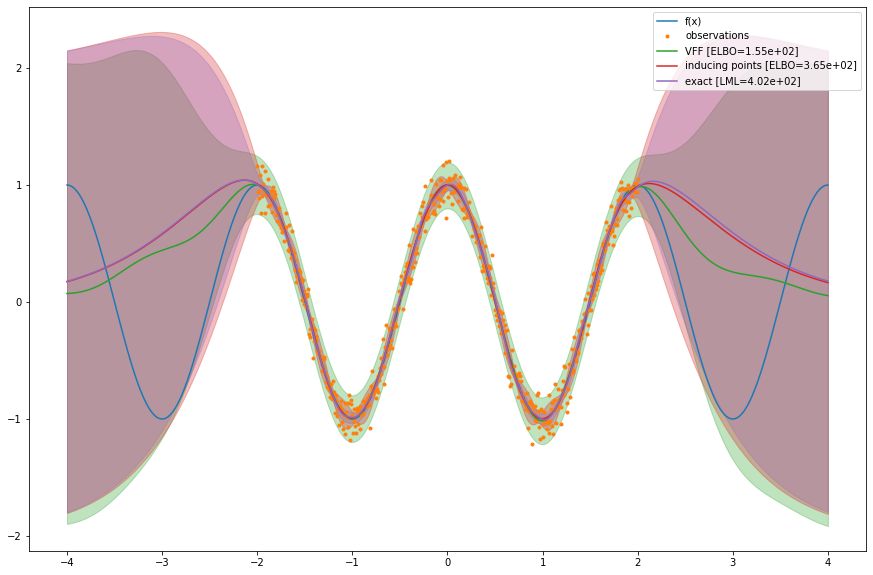

In [41]:
def plot_gp(m, Xnew, name=""):
    Fmean, Fvar = m.predict_f(Xnew[:, None])
    Fmean = Fmean.numpy().squeeze()
    Fvar = Fvar.numpy().squeeze()
    (p,) = plt.plot(Xnew, Fmean, label=name)
    plt.fill_between(
        Xnew, Fmean - 2 * np.sqrt(Fvar), Fmean + 2 * np.sqrt(Fvar), alpha=0.3, color=p.get_color()
    )


def plot_data():
    plt.plot(Xnew, Fnew, label="f(x)")
    plt.plot(X, Y, ".", label="observations")


plt.figure(figsize=(15, 10))
plot_data()
plot_gp(m, Xnew, "VFF [ELBO={:.3}]".format(vff_svgp_elbo))
plot_gp(m_ip, Xnew, "inducing points [ELBO={:.3}]".format(ip_svgp_elbo))
plot_gp(m_ref, Xnew, "exact [LML={:.3}]".format(exact_gpr_lml))
plt.legend(loc="best")
plt.show()